In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
df = pd.read_csv(Path.cwd() / 'data' / 'drp_scores.csv', skiprows=21, delimiter='\t')
df.head()

,Treatment,Response
0,Treated,24
1,Treated,43
2,Treated,58
3,Treated,71
4,Treated,43


In [3]:
grouped = df.groupby('Treatment')
responses = {}
for name, group in grouped:
    responses[name] = group['Response']

In [10]:
def make_uniform(qs, name=None, **options):
    pmf = Pmf(1.0, qs, **options)
    pmf.normalize()
    if name:
        pmf.index.name = name
    return pmf

In [11]:
qs_mu = np.linspace(20, 80, 101)
prior_mu = make_uniform(qs_mu, name='mean')

In [12]:
qs_sigma = np.linspace(5, 30, 101)
prior_sigma = make_uniform(qs_sigma, name='std')

In [13]:
def make_joint(pmf1, pmf2):
    X, Y = np.meshgrid(pmf1, pmf2)
    return pd.DataFrame(X * Y, columns=pmf1.qs, index=pmf2.qs)

In [14]:
prior = make_joint(prior_mu, prior_sigma)

In [15]:
data = responses['Control']

In [19]:
mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
mu_mesh.shape

(101, 101, 23)

In [21]:
densities = ss.norm(mu_mesh, sigma_mesh).pdf(data_mesh)
densities.shape

(101, 101, 23)

In [23]:
likelihood = densities.prod(axis=2)
likelihood.shape

(101, 101)

In [24]:
def normalize(joint):
    prob_data = joint.to_numpy().sum()
    joint /= prob_data
    return prob_data

In [25]:
posterior = prior * likelihood
normalize(posterior)

1.7918831921507705e-44

In [26]:
def update_norm(prior, data):
    mu_mesh, sigma_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
    densities = ss.norm(mu_mesh, sigma_mesh).pdf(data_mesh)
    likelihood = densities.prod(axis=2)

    posterior = prior * likelihood
    normalize(posterior)

    return posterior

In [27]:
data_con = responses['Control']
data_tr = responses['Treated']
posterior_control = update_norm(prior, data_con)
posterior_treated = update_norm(prior, data_tr)

In [28]:
def plot_contour(joint):
    fig, ax = plt.subplots(1, 1, figsize=(12, 3))
    ax.contour(joint.columns, joint.index, joint, linewidths=2)

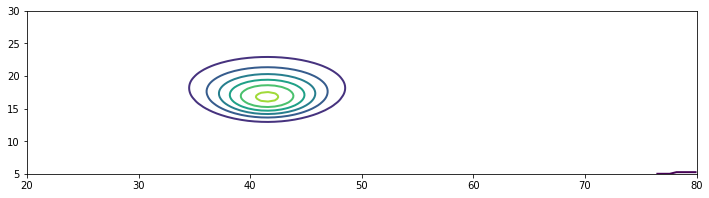

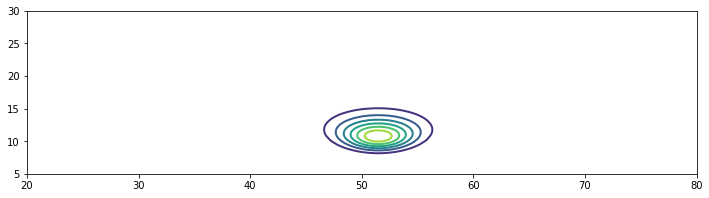

In [30]:
plot_contour(posterior_control)
plot_contour(posterior_treated)

In [31]:
def marginal(joint, axis):
    return Pmf(joint.sum(axis=axis))

In [32]:
pmf_mean_control = marginal(posterior_control, 0)
pmf_mean_treated = marginal(posterior_treated, 0)

In [33]:
Pmf.prob_gt(pmf_mean_treated, pmf_mean_control)

0.9804790251873259

In [34]:
pmf_diff = Pmf.sub_dist(pmf_mean_treated, pmf_mean_control)

In [51]:
def kde_from_pmf(pmf, n=101):
    kde = ss.gaussian_kde(pmf.qs, weights=abs(pmf.ps))
    qs = np.linspace(pmf.qs.min(), pmf.qs.max(), n)
    ps = kde.evaluate(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

In [52]:
kde_diff = kde_from_pmf(pmf_diff)

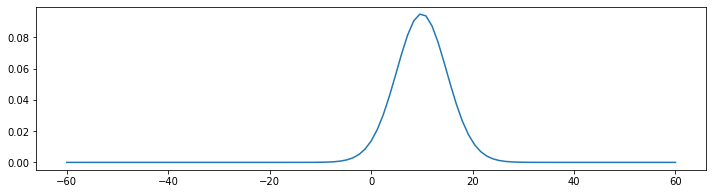

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.plot(kde_diff)

In [54]:
pmf_diff.mean(), pmf_diff.credible_interval(0.9)

(9.954413088940848, array([ 2.4, 17.4]))